In [1]:
import re
from datetime import datetime
import pandas as pd

Відкриваємо файл access.log з використанням регулярного виразу

In [2]:
def parse_log(line):
    pattern = re.compile(r'(\d+?\.\d+?\.\d+?\.\d+?) - - \[([\s\S]+?)] "(.+?) (/.+?) HTTP/(\d\.\d)" (\d+?) (\d+?) "(.+?)" "(.+?)" "-"')
    match = pattern.search(line)
    if match:
        ip, date, method, endpoint, version, status_code, length, x_forwarded_for, user_agent = match.groups()
        return {
            'ip': ip,
            'date': datetime.strptime(date, "%d/%b/%Y:%H:%M:%S %z"),
            'method': method,
            'endpoint': endpoint,
            'version': version,
            'status_code': status_code,
            'length': length,
            'x_forwarded_for': x_forwarded_for,
            'user_agent': user_agent
        }
    else:
        return None

data = []

with open("access.log", "r") as log:
    for line in log:
        p = parse_log(line)
        if p:
            data.append(p)

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [3]:
df

,ip,date,method,endpoint,version,status_code,length,x_forwarded_for,user_agent
0,13.66.139.0,2020-12-19 13:57:26+01:00,GET,/index.php?option=com_phocagallery&view=catego...,1.1,200,32653,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
1,157.48.153.185,2020-12-19 14:08:06+01:00,GET,/apache-log/access.log,1.1,200,233,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
2,157.48.153.185,2020-12-19 14:08:08+01:00,GET,/favicon.ico,1.1,404,217,http://www.almhuette-raith.at/apache-log/acces...,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...
3,216.244.66.230,2020-12-19 14:14:26+01:00,GET,/robots.txt,1.1,200,304,-,Mozilla/5.0 (compatible; DotBot/1.1; http://ww...
4,54.36.148.92,2020-12-19 14:16:44+01:00,GET,/index.php?option=com_phocagallery&view=catego...,1.1,200,30662,-,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...
...,...,...,...,...,...,...,...,...,...
10314203,77.47.227.21,2023-12-15 21:31:11+01:00,GET,/apache-log/access.log,1.1,200,261744,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...
10314204,77.47.227.21,2023-12-15 22:03:35+01:00,GET,/apache-log/access.log,1.1,200,1911246480,-,python-requests/2.31.0
10314205,178.238.164.48,2023-12-15 22:11:02+01:00,GET,/apache-log/access.log,1.1,200,21677120,-,python-requests/2.31.0
10314206,178.238.164.48,2023-12-15 22:16:08+01:00,GET,/apache-log/access.log,1.1,200,21889240,-,python-requests/2.31.0


Визначити кількість користувачів за днями

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

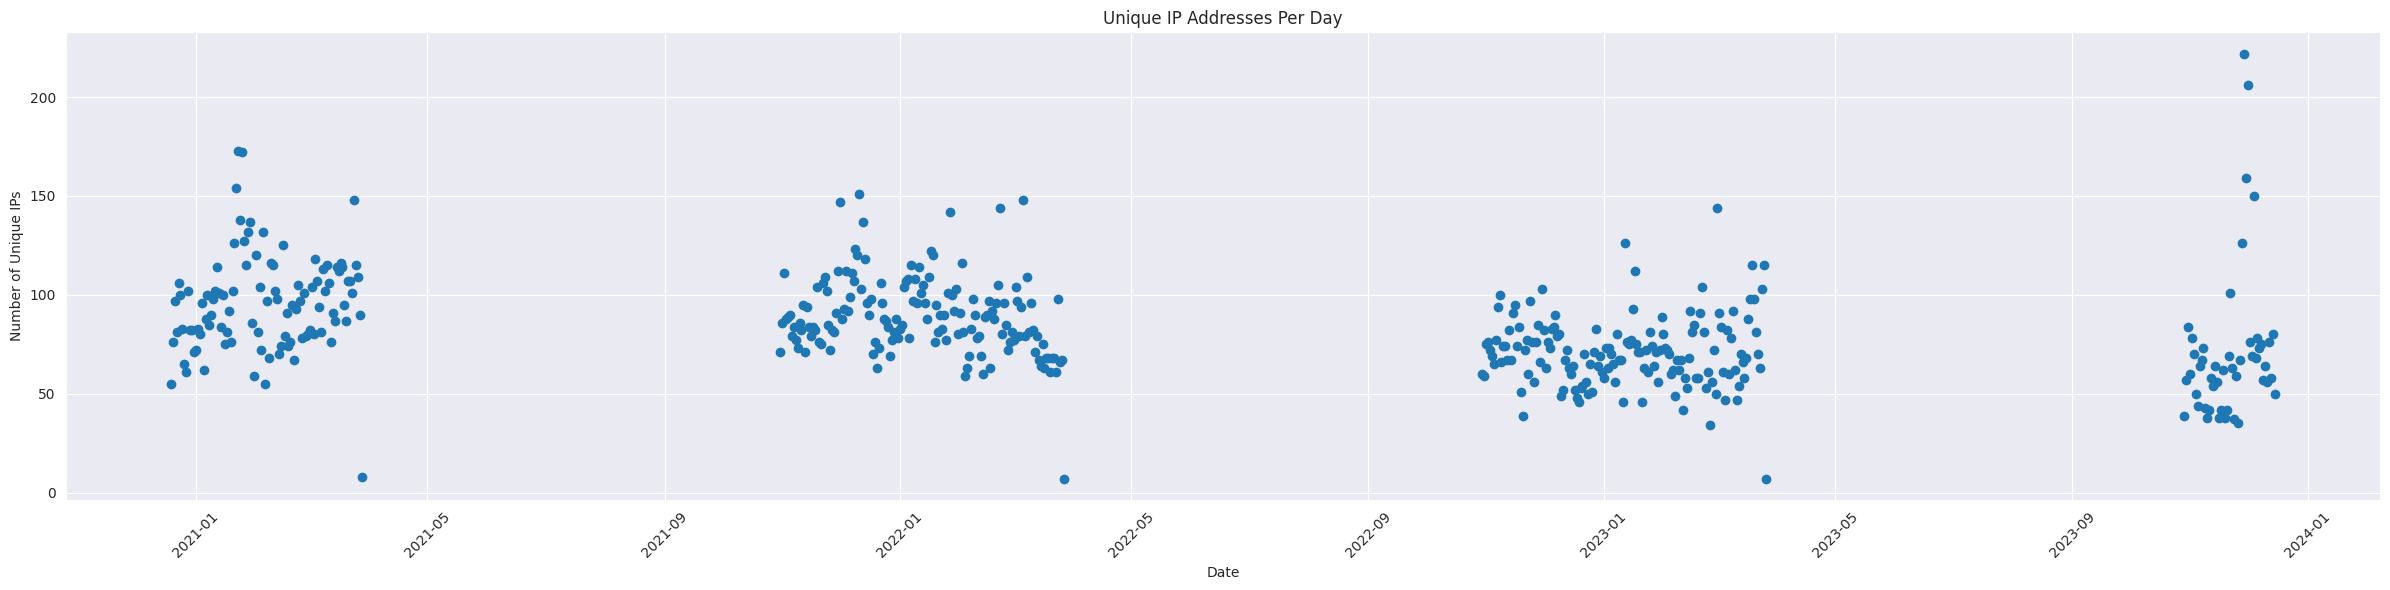

In [5]:
from matplotlib import pyplot as plt

df['day'] = df['date'].dt.date

unique_ips_per_day = df.groupby('day')['ip'].nunique()

plt.figure(figsize=(24, 6))
plt.scatter(unique_ips_per_day.index, unique_ips_per_day.values, marker='o')
plt.title('Unique IP Addresses Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Unique IPs')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ранжувати користувачів за User-Agent + визначення ботів

In [6]:
def categorize_user_agent(ua):
    ua = ua.lower()

    # Search Engine Bots
    if "bingbot" in ua:
        return "Bing Bot"
    elif "googlebot" in ua:
        return "Google Bot"
    elif "duckduckbot" in ua:
        return "DuckDuck Bot"
    elif "yandexbot" in ua:
        return "Yandex Bot"
    elif "ahrefsbot" in ua:
        return "Ahrefs Bot"
    elif "baiduspider" in ua:
        return "Baidu Bot"

    # Browsers
    elif "chrome" in ua:
        return "Chrome"
    elif "firefox" in ua:
        return "Firefox"
    elif "safari" in ua and "chrome" not in ua:  # Safari without Chrome
        return "Safari"
    elif "edge" in ua:
        return "Edge"
    elif "opera" in ua:
        return "Opera"

    # Other Clients
    elif "curl" in ua:
        return "cURL"
    elif "wget" in ua:
        return "Wget"
    elif "python" in ua:
        return "Python Script"

    return "Other"

df['user_agent_category'] = df['user_agent'].apply(categorize_user_agent)

In [7]:
df['user_agent_category'].unique()

array(['Bing Bot', 'Chrome', 'Other', 'Ahrefs Bot', 'Wget', 'Safari',
       'Firefox', 'Google Bot', 'cURL', 'Opera', 'Yandex Bot',
       'Python Script', 'DuckDuck Bot', 'Baidu Bot'], dtype=object)

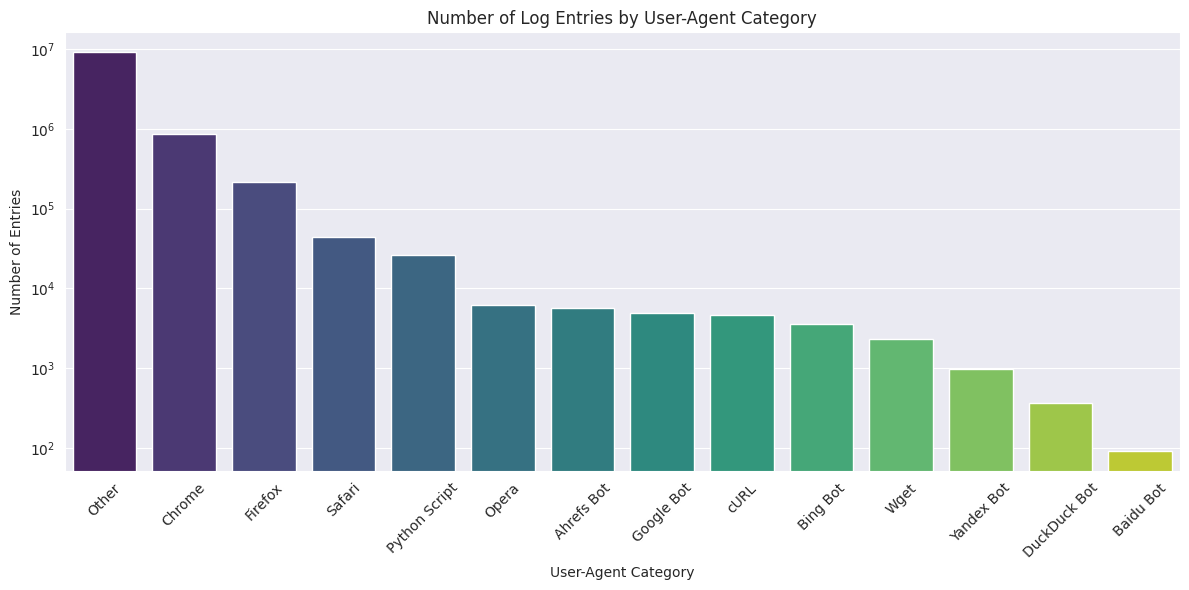

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

entries_by_ua_category = df['user_agent_category'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=entries_by_ua_category.index, y=entries_by_ua_category.values, hue=entries_by_ua_category.index, palette='viridis', legend=False)
plt.title('Number of Log Entries by User-Agent Category')
plt.xlabel('User-Agent Category')
plt.yscale('log')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ранжувати користувачів за операційними системами

In [9]:
def categorize_os(ua):
    ua = ua.lower()

    # Identify operating systems
    if "windows nt" in ua:
        return "Windows"
    elif "macintosh" in ua or "mac os x" in ua:
        return "MacOS"
    elif "android" in ua:
        return "Android"
    elif "linux" in ua and "ubuntu" not in ua:
        return "Linux"
    elif "iphone" in ua or "ipad" in ua:
        return "iOS"
    elif "unix" in ua:
        return "Unix"

    return "Other"  # For unknown or unrecognized OS

df['operating_system'] = df['user_agent'].apply(categorize_os)

In [10]:
df['operating_system'].unique()

array(['Other', 'Windows', 'Android', 'Linux', 'iOS', 'MacOS'],
      dtype=object)

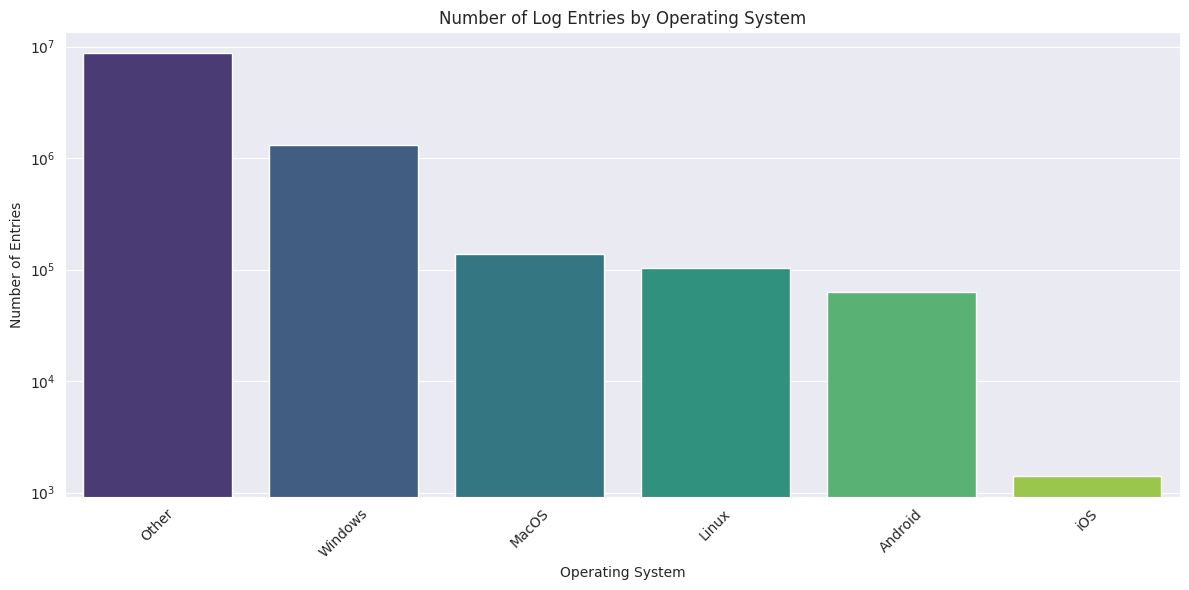

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

os_counts = df['operating_system'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=os_counts.index, y=os_counts.values, palette='viridis', legend=False, hue=os_counts.index)
plt.title('Number of Log Entries by Operating System')
plt.xlabel('Operating System')
plt.yscale('log')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ранжувати користувачів за країною запиту

In [12]:
import geoip2.database

reader = geoip2.database.Reader('GeoLite2-Country.mmdb')

def get_country_by_ip(ip):
    try:
        response = reader.country(ip)
        return response.country.iso_code
    except geoip2.errors.AddressNotFoundError:
        return 'Unknown'

unique_ips = df['ip'].unique()

ip_to_country = {ip: get_country_by_ip(ip) for ip in unique_ips}

df['country'] = df['ip'].map(ip_to_country)

reader.close()

In [13]:
df[['ip', 'country']]

,ip,country
0,13.66.139.0,US
1,157.48.153.185,IN
2,157.48.153.185,IN
3,216.244.66.230,US
4,54.36.148.92,FR
...,...,...
10314203,77.47.227.21,UA
10314204,77.47.227.21,UA
10314205,178.238.164.48,CH
10314206,178.238.164.48,CH


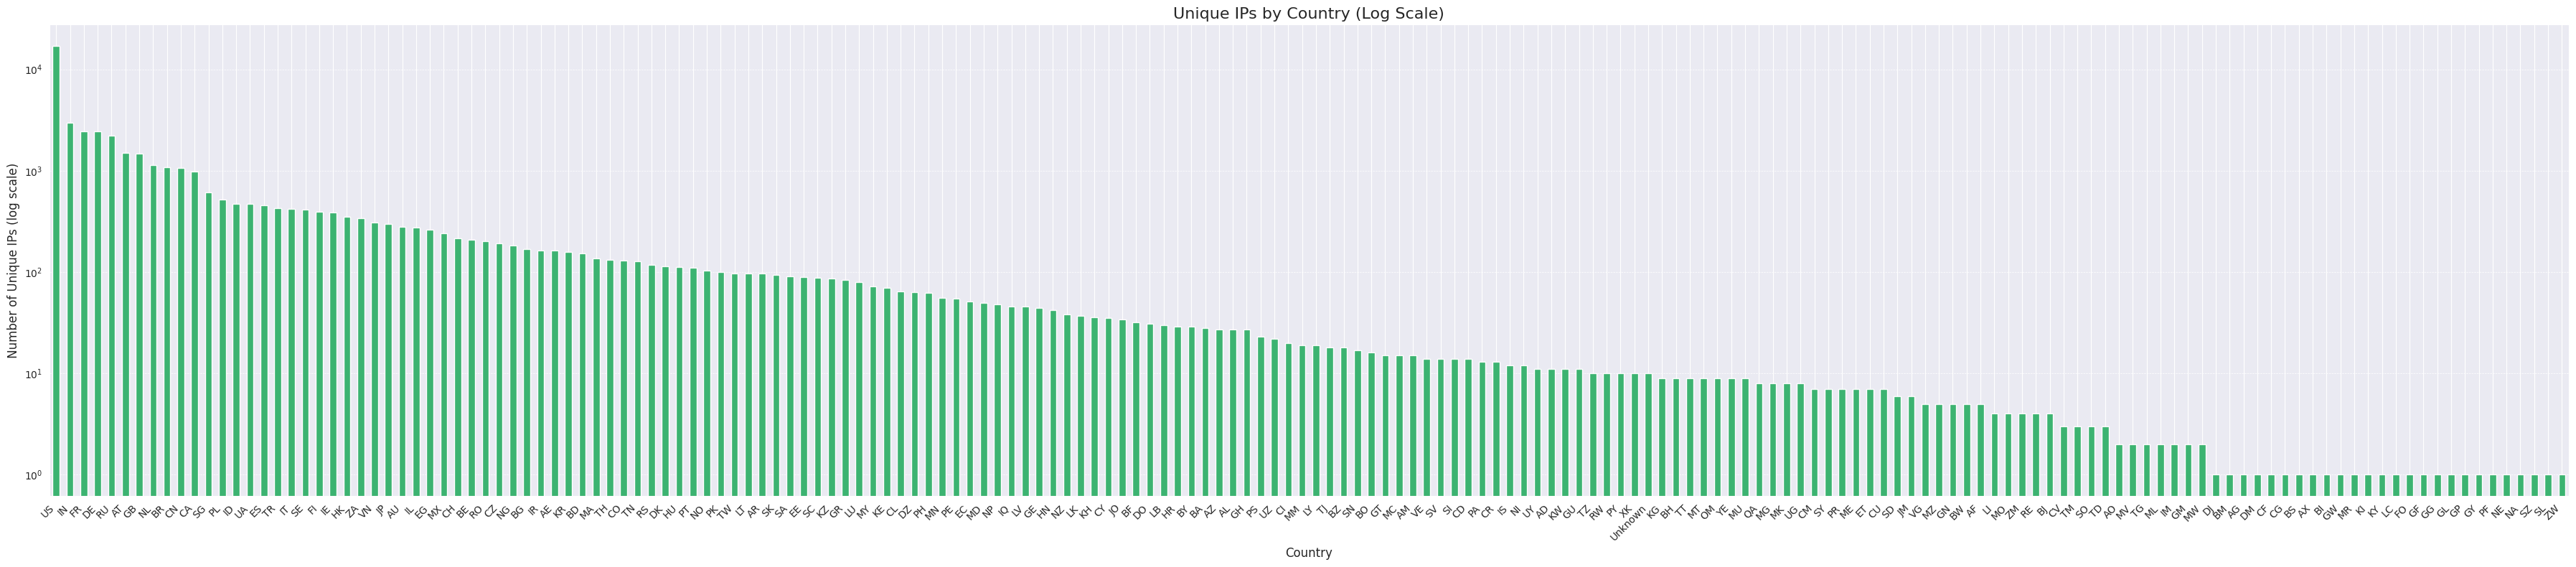

In [14]:
import matplotlib.pyplot as plt

unique_ips_per_country = df.groupby('country')['ip'].nunique().sort_values(ascending=False)

plt.figure(figsize=(36, 8))

unique_ips_per_country.plot(kind='bar', logy=True, color='mediumseagreen')

plt.title('Unique IPs by Country (Log Scale)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Unique IPs (log scale)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Детектувати аномалії (якщо такі є)

Аномалія: надмірно активні IP адреси

In [15]:
ip_counts = df['ip'].value_counts()

threshold = ip_counts.quantile(0.9999)  # Top 0.01% of IPs by activity
suspicious_ips = ip_counts[ip_counts > threshold]

print("Suspicious IPs:\n", suspicious_ips)

Suspicious IPs:
 ip
47.39.156.135     4304084
96.32.128.5       1959461
73.169.232.206    1572593
193.106.31.130     340856
82.209.218.4       333838
Name: count, dtype: int64


Аномалія: нетипові HTTP методи

In [16]:
common_methods = {'GET', 'POST', 'PUT', 'DELETE', 'HEAD', 'OPTIONS'}

unusual_methods = df[~df['method'].isin(common_methods)]

print("Unusual HTTP Methods Detected:\n", unusual_methods['method'].value_counts())

Unusual HTTP Methods Detected:
 method
PROPFIND                                                                                                                                                                   24
DEBUG                                                                                                                                                                       2
button.login.home=Se%20connecter&Login.userAgent=0x4148_Fu&reload=0&SSLVPNUser.Password=0x4148Fu&SSLVPNUser.UserName=0x4148&thispage=../../../../../../etc/passwd%00GET     1
Name: count, dtype: int64


Аномалія: нульова довжина (не зрозуміти, чи це довжина запиту чи відповіді)

In [17]:
df['length'] = pd.to_numeric(df['length'], errors='coerce')

zero_length_logs = df[df['length'] == 0]
print(f"Zero-length entries: {len(zero_length_logs)}")

Zero-length entries: 5698254


Дивлячись на те, що 5.7 мільйонів мають нульову довжину, то можна припустити, що це довжина відповіді, а не запиту, тому це не можна вважати аномалією